In [1]:
import pandas as pd
import numpy as np

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [4]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])

In [5]:
# drop the missing values rows
df.dropna(inplace=True)

In [6]:
df.shape

(714, 3)

In [7]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [8]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
X_train.head(2)

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542


In [12]:
clf = DecisionTreeClassifier()

In [13]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [14]:
accuracy_score(y_test,y_pred)

0.6223776223776224

In [15]:
# cross check
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,scoring='accuracy'))

0.6232542105781542

# Now by using Discretizer

In [25]:
kbin_age = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')

In [26]:
trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
])

In [27]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [28]:
trf.named_transformers_

{'first': KBinsDiscretizer(encode='ordinal', n_bins=10),
 'second': KBinsDiscretizer(encode='ordinal', n_bins=10)}

In [29]:
trf.named_transformers_['first'].n_bins_

array([10])

In [30]:
trf.named_transformers_['second']

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [31]:
trf.named_transformers_['second'].n_bins_

array([10])

In [33]:
# check range of bins of age column
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42, 14.  , 19.  , 22.  , 25.  , 28.5 , 32.  , 36.  , 42.  ,
              50.  , 80.  ])                                                ],
      dtype=object)

In [34]:
# check range of bins o fair column
trf.named_transformers_['second'].bin_edges_

array([array([  0.    ,   7.75  ,   7.8958,   9.225 ,  13.    ,  15.75  ,
               26.    ,  29.125 ,  51.4792,  82.1708, 512.3292])         ],
      dtype=object)

In [36]:
output = pd .DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})

In [38]:
output['age_labels'] = pd.cut(x=X_train['Age'],
                             bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'],
                              bins=trf.named_transformers_['second'].bin_edges_[0].tolist())

In [39]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
646,19.0,2.0,7.8958,2.0,"(14.0, 19.0]","(7.75, 7.896]"
795,39.0,7.0,13.0000,4.0,"(36.0, 42.0]","(9.225, 13.0]"
535,7.0,0.0,26.2500,6.0,"(0.42, 14.0]","(26.0, 29.125]"
579,32.0,6.0,7.9250,2.0,"(28.5, 32.0]","(7.896, 9.225]"
276,45.0,8.0,7.7500,1.0,"(42.0, 50.0]","(0.0, 7.75]"


In [41]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2 = clf.predict(X_test_trf)

In [42]:
accuracy_score(y_pred2,y_test)

# there is not so much change is accuracy so we can increase bin size from 10 to 15

0.6223776223776224

In [43]:
# cross check
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.6317488262910798

In [48]:
# make a function to do all this
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
    ])
    
    # cross check
    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title('Before Age Transform')
    
    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title('After Age Transform')
    
    plt.show()
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title('Before Fare Transform')
    
    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title('After Fare Transform')
    
    plt.show()

0.6303208137715179


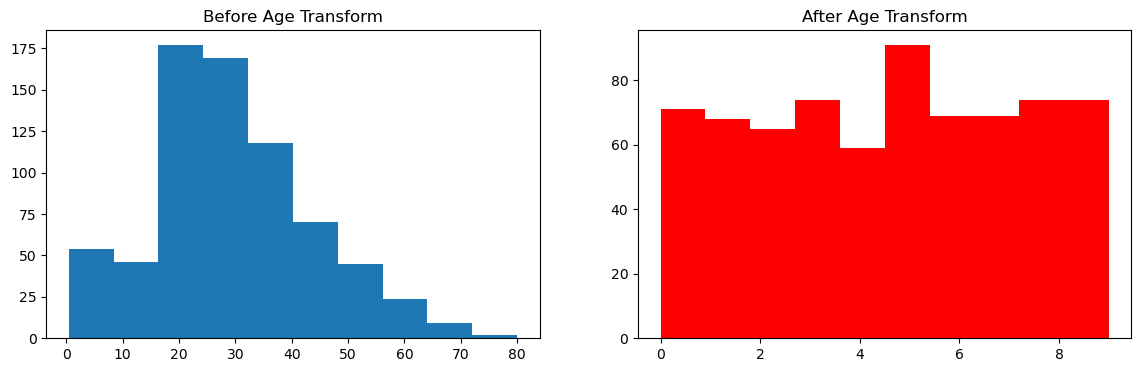

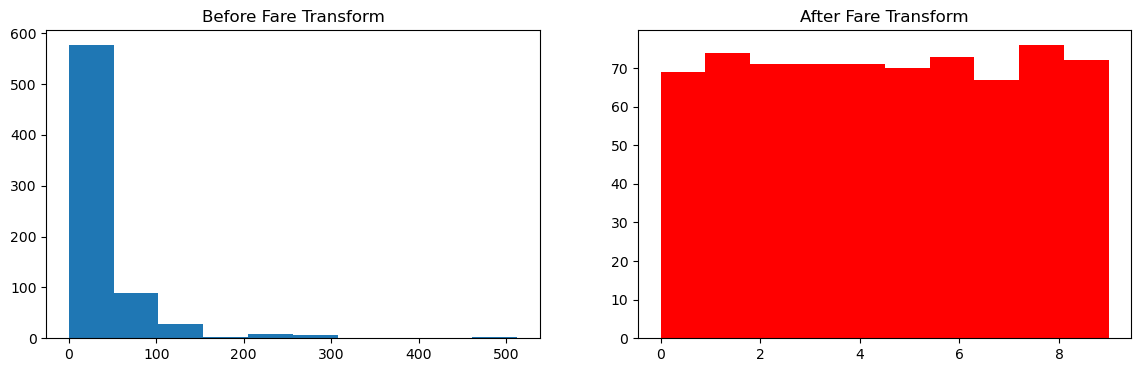

In [49]:
discretize(10,'quantile')

0.6386737089201877


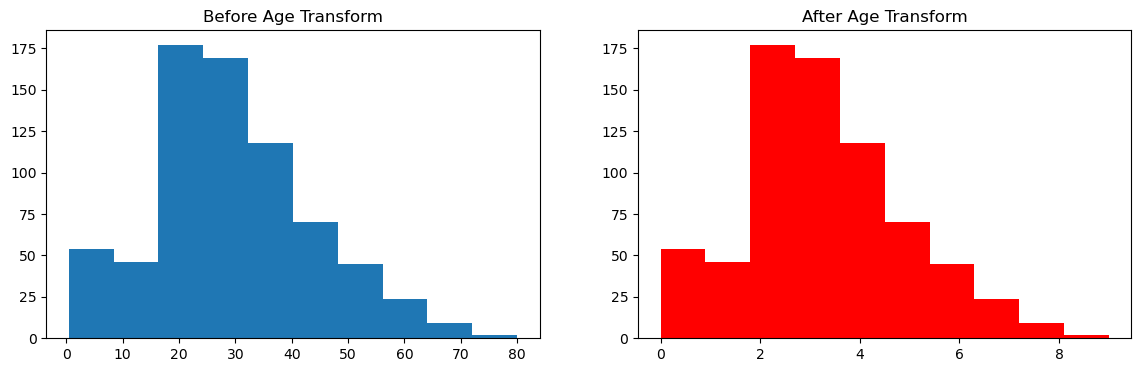

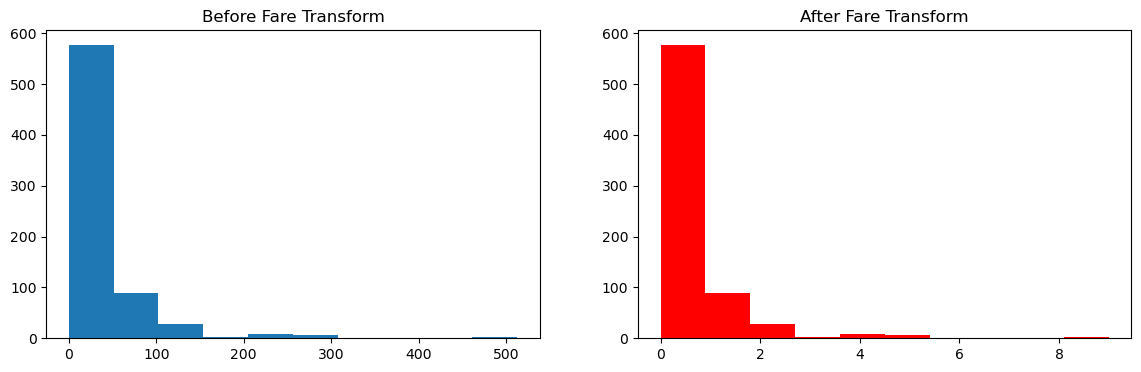

In [50]:
discretize(10,'uniform')

In [57]:
discretize(5,'kmeans')

AttributeError: 'NoneType' object has no attribute 'split'